In [2]:
%conda install pandas numpy scikit-learn beautifulsoup4 requests shap seaborn matplotlib -y

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/vladdenisov/miniconda3/envs/phishy

  added / updated specs:
    - beautifulsoup4
    - matplotlib
    - numpy
    - pandas
    - requests
    - scikit-learn
    - seaborn
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.12.3      |     pyha770c72_0         115 KB  conda-forge
    brotli-python-1.1.0        |  py311h3f08180_2         332 KB  conda-forge
    cffi-1.17.1                |  py311h3a79f62_0         281 KB  conda-forge
    charset-normalizer-3.4.0   |     pyhd8ed1ab_0          46 KB  conda-forge
    cloudpickle-3.1.0          |     pyhd8ed1ab_1          25 KB  conda-forge
    colorama-0.4.6             |     pyhd8ed1ab_0          25 KB  conda-forge
    h2-4.1.0                   |     pyhd8ed1ab_0          46 KB  co

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse
import re
import warnings
from sklearn.metrics import classification_report
import shap
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

In [74]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
import re
import shap
from typing import List, Dict, Union, Tuple
import logging

import numpy as np
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
import re
import shap
from typing import List, Dict, Union, Tuple
import logging

class HTMLPhishingDetector:
    def __init__(self, iterations: int = 1000, learning_rate: float = 0.1, random_state: int = 42):
        """
        Initialize the phishing detector with CatBoost and configurable parameters.
        
        Args:
            iterations: Number of boosting iterations (default: 1000)
            learning_rate: Learning rate for gradient descent (default: 0.1)
            random_state: Random seed for reproducibility (default: 42)
        """
        self.model = CatBoostClassifier(
            iterations=iterations,
            learning_rate=learning_rate,
            random_seed=random_state,
            verbose=True,
            eval_metric='AUC',
            loss_function='Logloss'
        )
        self.scaler = StandardScaler()
        self.feature_names: List[str] = []
        self.explainer = None
        
        # Configure logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def extract_html_features(self, html_content: str) -> np.ndarray:
        """
        Extract features from HTML content for phishing detection.
        
        Args:
            html_content: Raw HTML string
            
        Returns:
            np.ndarray: Array of extracted feature values
        """
        if not html_content or not isinstance(html_content, str):
            raise ValueError("HTML content must be a non-empty string")
            
        try:
            features = {}
            soup = BeautifulSoup(html_content, 'html.parser')
            
            # Form-related features
            forms = soup.find_all('form')
            features['form_count'] = len(forms)
            features['password_fields'] = len(soup.find_all('input', {'type': 'password'}))
            features['external_form_actions'] = sum(1 for form in forms 
                                                  if form.get('action', '').startswith(('http', '//')))
            
            # Enhanced link analysis
            links = soup.find_all('a')
            features['link_count'] = len(links)
            
            external_links = 0
            internal_links = 0
            suspicious_links = 0
            ip_pattern = re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
            
            for link in links:
                href = link.get('href', '').strip()
                if href.startswith(('http', '//', 'www.')):
                    external_links += 1
                    # Check for IP addresses in URLs
                    if ip_pattern.search(href):
                        suspicious_links += 1
                elif href and not href.startswith('#'):
                    internal_links += 1
                    
            total_links = external_links + internal_links
            features['external_links_ratio'] = (external_links / (total_links + 1)) if total_links > 0 else 0
            features['suspicious_link_ratio'] = (suspicious_links / (total_links + 1)) if total_links > 0 else 0
            
            # Enhanced script analysis
            scripts = soup.find_all('script')
            features['script_count'] = len(scripts)
            features['external_scripts'] = sum(1 for script in scripts 
                                            if script.get('src', '').startswith(('http', '//')))
            
            # Meta tags and favicon analysis
            meta_tags = soup.find_all('meta')
            features['meta_tag_count'] = len(meta_tags)
            features['has_favicon'] = int(bool(
                soup.find('link', rel=re.compile(r'^(shortcut\s+)?icon$', re.I))
            ))
            
            # Title analysis
            title = soup.find('title')
            features['has_title'] = int(bool(title))
            if title:
                features['title_length'] = len(title.text.strip())
            else:
                features['title_length'] = 0
            
            # Hidden elements detection
            hidden_pattern = re.compile(r'display\s*:\s*none|visibility\s*:\s*hidden', re.I)
            hidden_elements = soup.find_all(['input', 'div', 'span'], style=hidden_pattern)
            features['hidden_element_count'] = len(hidden_elements)
            
            # Enhanced security indicators
            features['has_https_link'] = int(bool(soup.find('a', href=re.compile(r'^https://'))))
            
            # Improved security text detection
            security_pattern = re.compile(
                r'security|secure|login|sign.?in|verify|confirm|update|account', re.I
            )
            features['has_security_text'] = int(bool(re.search(security_pattern, html_content)))
            
            # Content analysis
            text_content = ' '.join(soup.stripped_strings).lower()
            features['text_length'] = len(text_content)
            
            # Enhanced urgent text detection
            urgent_pattern = re.compile(
                r'urgent|immediate|action\s+required|verify.?account|limited.?time|expires?|deadline', re.I
            )
            features['has_urgent_text'] = int(bool(re.search(urgent_pattern, text_content)))
            
            # Enhanced input field analysis
            input_fields = soup.find_all('input')
            features['input_field_count'] = len(input_fields)
            
            sensitive_types = {'password', 'email', 'tel', 'credit-card', 'card-number', 'ssn'}
            features['sensitive_input_count'] = sum(
                1 for field in input_fields 
                if field.get('type', '').lower() in sensitive_types 
                or any(term in field.get('name', '').lower() for term in sensitive_types)
            )
            
            # Form submission analysis
            features['has_submit_button'] = int(bool(
                soup.find('input', {'type': 'submit'}) or 
                soup.find('button', {'type': 'submit'})
            ))
            
            return np.array(list(features.values()))
            
        except Exception as e:
            self.logger.error(f"Error extracting features: {str(e)}")
            raise

    def prepare_dataset(self, html_contents: List[str], labels: List[int]) -> np.ndarray:
        """
        Prepare features from multiple HTML contents.
        """
        if len(html_contents) != len(labels):
            raise ValueError("Number of HTML contents must match number of labels")
            
        features_list = []
        for i, html in enumerate(html_contents):
            try:
                features_list.append(self.extract_html_features(html))
            except Exception as e:
                self.logger.warning(f"Failed to extract features for sample {i}: {str(e)}")
                continue
        
        features_array = np.array(features_list)
        
        self.feature_names = [
            'form_count', 'password_fields', 'external_form_actions',
            'link_count', 'external_links_ratio', 'suspicious_link_ratio',
            'script_count', 'external_scripts', 'meta_tag_count',
            'has_favicon', 'has_title', 'title_length',
            'hidden_element_count', 'has_https_link', 'has_security_text',
            'text_length', 'has_urgent_text', 'input_field_count',
            'sensitive_input_count', 'has_submit_button'
        ]
        
        return features_array

    def train(self, X: np.ndarray, y: np.ndarray) -> 'HTMLPhishingDetector':
        """
        Train the phishing detection model using CatBoost.
        """
        if X.shape[1] != len(self.feature_names):
            raise ValueError(f"Expected {len(self.feature_names)} features, got {X.shape[1]}")
            
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Train CatBoost model
        self.model.fit(X_scaled, y, verbose=False)
        
        # Initialize SHAP explainer
        try:
            self.explainer = shap.TreeExplainer(self.model)
        except Exception as e:
            self.logger.warning(f"Failed to initialize SHAP explainer: {str(e)}")
            self.explainer = None
        
        return self

    def predict(self, html_content: str) -> Dict[str, Union[bool, float, str, List]]:
        """
        Predict whether HTML content is from a phishing page and explain why.
        """
        try:
            features = self.extract_html_features(html_content)
            features_scaled = self.scaler.transform(features.reshape(1, -1))
            
            prediction = self.model.predict(features_scaled)[0]
            probability = self.model.predict_proba(features_scaled)[0]
            
            explanation = "No explanation available"
            feature_importance = []
            
            if self.explainer:
                try:
                    shap_values = self.explainer.shap_values(features_scaled)
                    if isinstance(shap_values, list):
                        shap_vals = shap_values[1][0] if prediction == 1 else shap_values[0][0]
                    else:
                        shap_vals = shap_values[0]
                    
                    explanation = self._generate_explanation(features, shap_vals)
                    feature_importance = self._get_feature_importance(features, shap_vals)
                except Exception as e:
                    self.logger.warning(f"Failed to generate SHAP explanation: {str(e)}")
            
            suspicious_elements = self._identify_suspicious_elements(html_content)
            
            return {
                'is_phishing': bool(prediction),
                'confidence': float(max(probability)),
                'explanation': explanation,
                'feature_importance': feature_importance[:5],
                'suspicious_elements': suspicious_elements,
                'feature_values': dict(zip(self.feature_names, features))
            }
            
        except Exception as e:
            self.logger.error(f"Prediction error: {str(e)}")
            raise

    def _generate_explanation(self, features: np.ndarray, shap_values: np.ndarray) -> str:
        """Generate detailed human-readable explanation based on SHAP values."""
        try:
            feature_importance = self._get_feature_importance(features, shap_values)
            explanations = []
            
            for feature, value, importance in feature_importance[:5]:
                if abs(importance) < 0.1:
                    continue
                    
                if feature == 'external_links_ratio':
                    explanations.append(
                        f"Соотношение внешних ссылок ({value:.2f}) "
                        f"{'необычно высокое' if importance > 0 else 'нормальное'}"
                    )
                elif feature == 'suspicious_link_ratio' and value > 0:
                    explanations.append(
                        f"Содержит подозрительные ссылки (например, IP-адреса в URL)"
                    )
                elif feature == 'password_fields':
                    explanations.append(
                        f"Количество полей для пароля ({int(value)}) "
                        f"{'подозрительное' if importance > 0 else 'нормальное'}"
                    )
                elif feature == 'hidden_element_count':
                    explanations.append(
                        f"Количество скрытых элементов ({int(value)}) "
                        f"{'подозрительное' if importance > 0 else 'нормальное'}"
                    )
                elif feature == 'has_urgent_text' and value == 1:
                    explanations.append("Страница содержит срочные или угрожающие формулировки")
                elif feature == 'sensitive_input_count':
                    explanations.append(
                        f"Количество полей для ввода конфиденциальных данных ({int(value)}) "
                        f"{'подозрительное' if importance > 0 else 'нормальное'}"
                    )
                    
            return ' и '.join(explanations) + '.' if explanations else "Значительных подозрительных признаков не обнаружено."
            
        except Exception as e:
            self.logger.warning(f"Failed to generate explanation: {str(e)}")
            return "Error generating explanation"

    def _get_feature_importance(
        self, 
        features: np.ndarray, 
        shap_values: np.ndarray
    ) -> List[Tuple[str, float, float]]:
        """Calculate feature importance using SHAP values."""
        feature_importance = []
        
        for name, value, importance in zip(self.feature_names, features, shap_values):
            value = float(np.asarray(value).item() if hasattr(value, 'item') else value)
            importance = float(np.asarray(importance).item() if hasattr(importance, 'item') else importance)
            feature_importance.append((name, value, importance))
        
        return sorted(feature_importance, key=lambda x: abs(x[2]), reverse=True)

    def _identify_suspicious_elements(self, html_content: str) -> List[Dict[str, str]]:
        """Identify specific suspicious elements in the HTML content."""
        try:
            soup = BeautifulSoup(html_content, 'html.parser')
            suspicious = []
            
            # Check for forms with external actions
            for form in soup.find_all('form'):
                action = form.get('action', '')
                if action.startswith(('http', '//')):
                    suspicious.append({
                        'type': 'script',
                        'issue': 'Suspicious script content',
                        'element': str(script)[:200] + '...' if len(str(script)) > 200 else str(script)
                    })

            # Check for suspicious iframes
            iframes = soup.find_all('iframe')
            for iframe in iframes:
                src = iframe.get('src', '')
                if src.startswith(('http', '//')) or not src:
                    suspicious.append({
                        'type': 'iframe',
                        'issue': 'Suspicious iframe usage',
                        'element': str(iframe)
                    })

            # Check for data URIs in links or forms
            elements_with_uri = soup.find_all(['a', 'form', 'img'], href=re.compile(r'^data:'))
            for element in elements_with_uri:
                suspicious.append({
                    'type': element.name,
                    'issue': 'Suspicious data URI usage',
                    'element': str(element)
                })

            # Check for obfuscated JavaScript
            scripts = soup.find_all('script')
            obfuscation_patterns = re.compile(
                r'eval\(|String\.fromCharCode|unescape\(|escape\(|atob\(|btoa\(|' +
                r'decodeURIComponent\(|encodeURIComponent\('
            )
            
            for script in scripts:
                content = script.string if script.string else ''
                if content and obfuscation_patterns.search(content):
                    suspicious.append({
                        'type': 'script',
                        'issue': 'Potentially obfuscated JavaScript',
                        'element': str(script)[:200] + '...' if len(str(script)) > 200 else str(script)
                    })

            # Check for mixed content (HTTP content on HTTPS pages)
            if soup.find('meta', {'content': re.compile('https')}):
                mixed_content = soup.find_all(['img', 'script', 'link', 'iframe'], 
                                            src=re.compile(r'^http:\/\/'))
                for element in mixed_content:
                    suspicious.append({
                        'type': element.name,
                        'issue': 'Mixed content (HTTP on HTTPS)',
                        'element': str(element)
                    })

            return suspicious
            
        except Exception as e:
            # self.logger.error(f"Error identifying suspicious elements: {str(e)}")
            return []

    def get_model_feature_importance(self) -> List[Tuple[str, float]]:
        """
        Get global feature importance from the trained CatBoost model.
        
        Returns:
            List of tuples containing feature names and their importance scores
        """
        if not hasattr(self.model, 'feature_importances_'):
            raise ValueError("Model has not been trained yet")
            
        importances = self.model.feature_importances_
        feature_importance = list(zip(self.feature_names, importances))
        return sorted(feature_importance, key=lambda x: x[1], reverse=True)

    def get_feature_correlations(self, X: np.ndarray) -> Dict[str, List[Tuple[str, float]]]:
        """
        Calculate correlations between features.
        
        Args:
            X: Feature matrix
            
        Returns:
            Dictionary mapping each feature to its most correlated features
        """
        try:
            import pandas as pd
            
            df = pd.DataFrame(X, columns=self.feature_names)
            corr_matrix = df.corr()
            
            correlations = {}
            for feature in self.feature_names:
                # Get correlations for this feature, sorted by absolute value
                feature_corrs = [(other_feat, corr) 
                               for other_feat, corr in corr_matrix[feature].items()
                               if other_feat != feature]
                feature_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
                correlations[feature] = feature_corrs[:5]  # Top 5 correlations
                
            return correlations
            
        except Exception as e:
            self.logger.error(f"Error calculating feature correlations: {str(e)}")
            return {}

In [11]:
import numpy as np
import json
import pickle
from typing import Tuple, List, Dict
import logging
from pathlib import Path
import os

class DatasetUtils:
    def __init__(self):
        self.logger = logging.getLogger(__name__)
        
    def save_prepared_dataset(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        feature_names: List[str], 
        filepath: str,
        metadata: Dict = None
    ) -> bool:
        """
        Save prepared dataset (X, y) along with feature names and optional metadata.
        
        Args:
            X: Feature matrix
            y: Labels
            feature_names: List of feature names
            filepath: Path to save the dataset
            metadata: Optional dictionary with additional metadata
            
        Returns:
            bool: True if save was successful
        """
        try:
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            
            data_dict = {
                'X': X,
                'y': y,
                'feature_names': feature_names,
                'metadata': metadata or {},
                'shape': X.shape,
                'created_at': str(np.datetime64('now'))
            }
            
            with open(filepath, 'wb') as f:
                pickle.dump(data_dict, f)
                
            self.logger.info(f"Dataset saved successfully to {filepath}")
            self.logger.info(f"Dataset shape: {X.shape}")
            return True
            
        except Exception as e:
            self.logger.error(f"Error saving dataset: {str(e)}")
            return False
            
    def load_prepared_dataset(
        self, 
        filepath: str
    ) -> Tuple[np.ndarray, np.ndarray, List[str], Dict]:
        """
        Load prepared dataset from file.
        
        Args:
            filepath: Path to the saved dataset
            
        Returns:
            Tuple containing:
            - X: Feature matrix
            - y: Labels
            - feature_names: List of feature names
            - metadata: Dictionary with additional metadata
            
        Raises:
            FileNotFoundError: If file doesn't exist
            ValueError: If file format is invalid
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Dataset file not found: {filepath}")
            
        try:
            with open(filepath, 'rb') as f:
                data_dict = pickle.load(f)
                
            # Verify data structure
            required_keys = {'X', 'y', 'feature_names', 'metadata', 'shape'}
            if not all(key in data_dict for key in required_keys):
                raise ValueError("Invalid dataset format: missing required keys")
                
            # Verify shapes match
            if data_dict['X'].shape != data_dict['shape']:
                raise ValueError("Data corruption detected: shapes don't match")
                
            self.logger.info(f"Dataset loaded successfully from {filepath}")
            self.logger.info(f"Dataset shape: {data_dict['X'].shape}")
            
            return (
                data_dict['X'],
                data_dict['y'],
                data_dict['feature_names'],
                data_dict['metadata']
            )
            
        except Exception as e:
            self.logger.error(f"Error loading dataset: {str(e)}")
            raise

    def save_features_batch(
        self,
        features_list: List[np.ndarray],
        batch_size: int = 1000,
        output_dir: str = 'features_batches'
    ) -> List[str]:
        """
        Save large feature matrices in batches.
        
        Args:
            features_list: List of feature arrays
            batch_size: Number of samples per batch
            output_dir: Directory to save batches
            
        Returns:
            List of paths to saved batch files
        """
        try:
            os.makedirs(output_dir, exist_ok=True)
            batch_files = []
            
            for i in range(0, len(features_list), batch_size):
                batch = features_list[i:i + batch_size]
                batch_array = np.array(batch)
                
                batch_file = os.path.join(output_dir, f'features_batch_{i//batch_size}.npy')
                np.save(batch_file, batch_array)
                batch_files.append(batch_file)
                
            self.logger.info(f"Saved {len(batch_files)} feature batches")
            return batch_files
            
        except Exception as e:
            self.logger.error(f"Error saving feature batches: {str(e)}")
            raise

    def load_features_batch(
        self,
        batch_files: List[str]
    ) -> np.ndarray:
        """
        Load and combine feature batches.
        
        Args:
            batch_files: List of paths to batch files
            
        Returns:
            Combined feature matrix
        """
        try:
            features_list = []
            
            for batch_file in batch_files:
                batch_array = np.load(batch_file)
                features_list.append(batch_array)
                
            combined_features = np.vstack(features_list)
            self.logger.info(f"Loaded features with shape: {combined_features.shape}")
            return combined_features
            
        except Exception as e:
            self.logger.error(f"Error loading feature batches: {str(e)}")
            raise

    def verify_dataset_integrity(
        self,
        filepath: str
    ) -> bool:
        """
        Verify the integrity of a saved dataset.
        
        Args:
            filepath: Path to the dataset file
            
        Returns:
            bool: True if dataset is valid
        """
        try:
            with open(filepath, 'rb') as f:
                data_dict = pickle.load(f)
                
            # Check required keys
            required_keys = {'X', 'y', 'feature_names', 'metadata', 'shape'}
            if not all(key in data_dict for key in required_keys):
                self.logger.error("Missing required keys in dataset")
                return False
                
            # Check shapes
            if data_dict['X'].shape != data_dict['shape']:
                self.logger.error("Shape mismatch in dataset")
                return False
                
            # Check feature names match feature count
            if len(data_dict['feature_names']) != data_dict['X'].shape[1]:
                self.logger.error("Feature names count doesn't match feature count")
                return False
                
            # Check for NaN values
            if np.isnan(data_dict['X']).any() or np.isnan(data_dict['y']).any():
                self.logger.error("Dataset contains NaN values")
                return False
                
            self.logger.info("Dataset integrity verified successfully")
            return True
            
        except Exception as e:
            self.logger.error(f"Error verifying dataset: {str(e)}")
            return False

In [6]:
import json
data = json.load(open('webs.json', 'r', encoding='utf-8'))[:10000]

In [12]:
utils = DatasetUtils()

In [7]:
html_contents = [item['text'] for item in data]
labels = [item['label'] for item in data]

In [75]:
# Initialize detector
detector = HTMLPhishingDetector(
    iterations=1000,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    random_state=42  # Random seed
)


In [76]:
# Prepare dataset
X = detector.prepare_dataset(html_contents, labels)
y = np.array(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
# Save dataset
save_path = "./prepared_dataset.pkl"
metadata = {
    'description': 'HTML phishing detection features',
        'num_samples': len(labels),
        'positive_samples': sum(labels)
    }
utils.save_prepared_dataset(
        X=X,
        y=y,
        feature_names=detector.feature_names,
        filepath=save_path,
    metadata=metadata
)

INFO:__main__:Dataset saved successfully to ./prepared_dataset.pkl
INFO:__main__:Dataset shape: (10000, 20)


True

In [70]:
# Later, load the dataset
X_loaded, y_loaded, feature_names, metadata = utils.load_prepared_dataset(save_path)

INFO:__main__:Dataset loaded successfully from ./prepared_dataset.pkl
INFO:__main__:Dataset shape: (10000, 20)


In [ ]:
# Example usage:
def example_usage():
    # Initialize utilities
    
    
    # Prepare your dataset (example)
    detector = HTMLPhishingDetector()
    X = detector.prepare_dataset(html_contents, labels)
    y = np.array(labels)
    
    # For large datasets, use batch processing
    batch_files = utils.save_features_batch(
        features_list=X.tolist(),
        batch_size=1000,
        output_dir='feature_batches'
    )
    
    # Load batches when needed
    X_combined = utils.load_features_batch(batch_files)
    
    # Verify dataset integrity
    is_valid = utils.verify_dataset_integrity(save_path)

In [77]:
detector.train(X_train, y_train)

In [17]:
alll =json.load(open('webs.json', 'r', encoding='utf-8'))

In [19]:
len(alll)

15756

In [49]:
def get_random_sample():
    rng = np.random.default_rng()
    idx = rng.integers(0, len(alll))
    return alll[idx]['text'], alll[idx]['label']

In [97]:
sample_html, true_label = get_random_sample()
result = detector.predict(sample_html)
print(f"Is phishing: {result['is_phishing']}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"Explanation: {result['explanation']}")
print(f"Suspicious elements: {result['suspicious_elements']}")
print(f"True label: {'Phishing' if true_label == 1 else 'Legitimate'}")
print(f"Is model correct: {result['is_phishing'] == (true_label == 1)}")

Is phishing: True
Confidence: 0.72
Explanation: Количество скрытых элементов (5) подозрительное и Соотношение внешних ссылок (0.00) необычно высокое.
Suspicious elements: []
True label: Phishing
Is model correct: True


In [63]:
def test_model(detector, n_tests=100):
    correct = 0
    for i in range(n_tests):
        sample_html, true_label = get_random_sample()
        result = detector.predict(sample_html)
        correct += result['is_phishing'] == (true_label == 1)
    return correct / n_tests

In [94]:
test_model(detector, n_tests=1000)

0.961

In [22]:
result

{'is_phishing': False,
 'confidence': 0.9999114840223284,
 'explanation': 'The page contains urgent or threatening language.',
 'feature_importance': [('text_length', 38640.0, -3.0330556120506316),
  ('link_count', 33.0, -1.1929234857212316),
  ('meta_tag_count', 39.0, -1.18454137311926),
  ('has_urgent_text', 1.0, -0.7294605416411305),
  ('has_favicon', 0.0, -0.6479692336794542)],
 'suspicious_elements': [],
 'feature_values': {'form_count': 0.0,
  'password_fields': 0.0,
  'external_form_actions': 0.0,
  'link_count': 33.0,
  'external_links_ratio': 0.9615384615384616,
  'suspicious_link_ratio': 0.0,
  'script_count': 5.0,
  'external_scripts': 2.0,
  'meta_tag_count': 39.0,
  'has_favicon': 0.0,
  'has_title': 1.0,
  'title_length': 33.0,
  'hidden_element_count': 0.0,
  'has_https_link': 1.0,
  'has_security_text': 1.0,
  'text_length': 38640.0,
  'has_urgent_text': 1.0,
  'input_field_count': 0.0,
  'sensitive_input_count': 0.0,
  'has_submit_button': 0.0}}

In [186]:
detector = HTMLPhishingDetector()

In [187]:
X = detector.prepare_dataset(html_contents, labels)
y = np.array(labels)

In [188]:
print(f"Dataset size: {len(labels)} samples")
print(f"Feature count: {X.shape[1]} features")
print(f"Class distribution: {np.bincount(y)}")

Dataset size: 10000 samples
Feature count: 16 features
Class distribution: [6341 3659]


In [98]:
class ModelPersistence:
    @staticmethod
    def save_model(detector: 'HTMLPhishingDetector', filepath: str) -> bool:
        """
        Save the trained model and its components to a file.
        
        Args:
            detector: Trained HTMLPhishingDetector instance
            filepath: Path where to save the model
            
        Returns:
            bool: True if save was successful
        """
        try:
            model_state = {
                'model': detector.model,
                'scaler': detector.scaler,
                'feature_names': detector.feature_names,
                'explainer': detector.explainer
            }
            
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            with open(filepath, 'wb') as f:
                pickle.dump(model_state, f)
            
            return True
        except Exception as e:
            detector.logger.error(f"Error saving model: {str(e)}")
            return False

    @staticmethod
    def load_model(filepath: str) -> 'HTMLPhishingDetector':
        """
        Load a saved model and its components.
        
        Args:
            filepath: Path to the saved model file
            
        Returns:
            HTMLPhishingDetector: Loaded model instance
            
        Raises:
            FileNotFoundError: If model file doesn't exist
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")
            
        try:
            with open(filepath, 'rb') as f:
                model_state = pickle.load(f)
                
            detector = HTMLPhishingDetector()
            detector.model = model_state['model']
            detector.scaler = model_state['scaler']
            detector.feature_names = model_state['feature_names']
            detector.explainer = model_state['explainer']
            
            return detector
        except Exception as e:
            raise RuntimeError(f"Error loading model: {str(e)}")

# Add model persistence methods to HTMLPhishingDetector
def save(self, filepath: str) -> bool:
    """Save the model to a file."""
    return ModelPersistence.save_model(self, filepath)

def load(cls, filepath: str) -> 'HTMLPhishingDetector':
    """Load the model from a file."""
    return ModelPersistence.load_model(filepath)

# Add these methods to HTMLPhishingDetector class
HTMLPhishingDetector.save = save
HTMLPhishingDetector.load = classmethod(load)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y  # Ensure balanced split
)

In [190]:
detector.train(X_train, y_train)

In [99]:
detector.save("models/phishing_detector.pkl")

True

In [28]:
y_pred = detector.model.predict(detector.scaler.transform(X_test))
 
print("\nModel Performance:")
print(classification_report(y_test, y_pred))


Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1268
           1       0.89      0.89      0.89       732

    accuracy                           0.92      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.92      0.92      0.92      2000



In [8]:
result = detector.predict(sample_html)
    
print(f"\nTrue label: {'Phishing' if true_label == 1 else 'Legitimate'}")
print(f"Predicted: {'Phishing' if result['is_phishing'] else 'Legitimate'}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"Explanation: {result['explanation']}")
    
print("\nSuspicious Elements Found:")
for element in result['suspicious_elements']:
    print(f"\nType: {element['type']}")
    print(f"Issue: {element['issue']}")
    print("Element preview:", element['element'][:200], "..." if len(element['element']) > 200 else "")

NameError: name 'true_label' is not defined

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


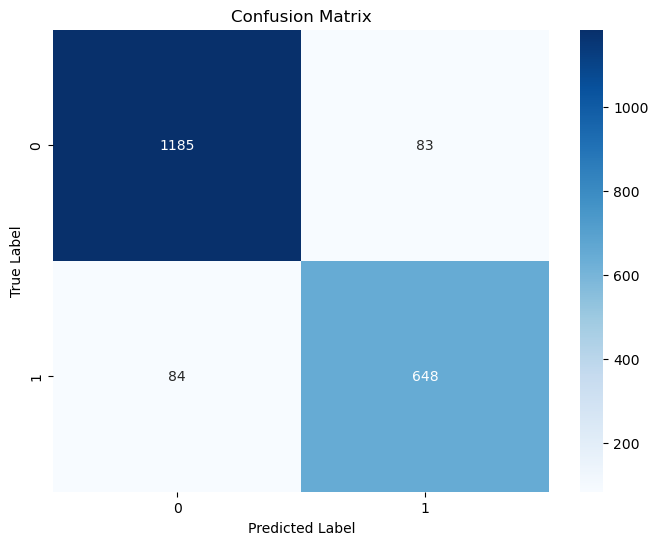

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [30]:
feature_imp = pd.DataFrame({
    'feature': detector.feature_names,
    'importance': detector.model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_imp.head(10))


Top 10 Most Important Features:
                 feature  importance
15           text_length   13.312598
3             link_count   11.953776
6           script_count   10.419127
11          title_length    9.310847
4   external_links_ratio    8.956570
8         meta_tag_count    8.747403
17     input_field_count    7.350063
7       external_scripts    7.038677
12  hidden_element_count    4.090276
1        password_fields    3.721729


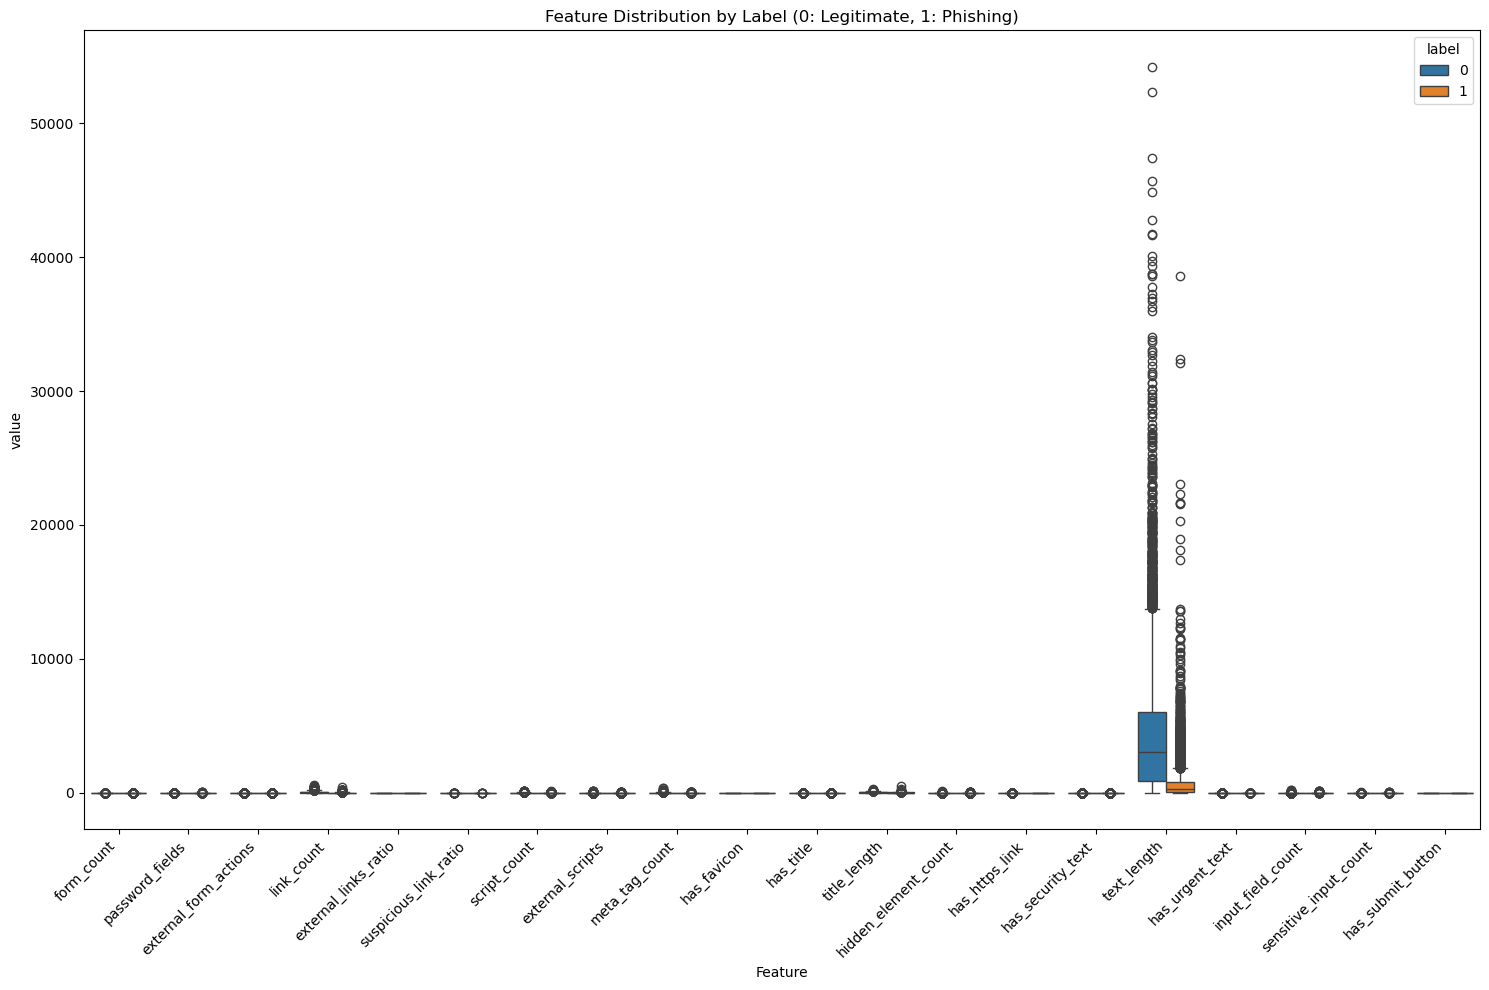

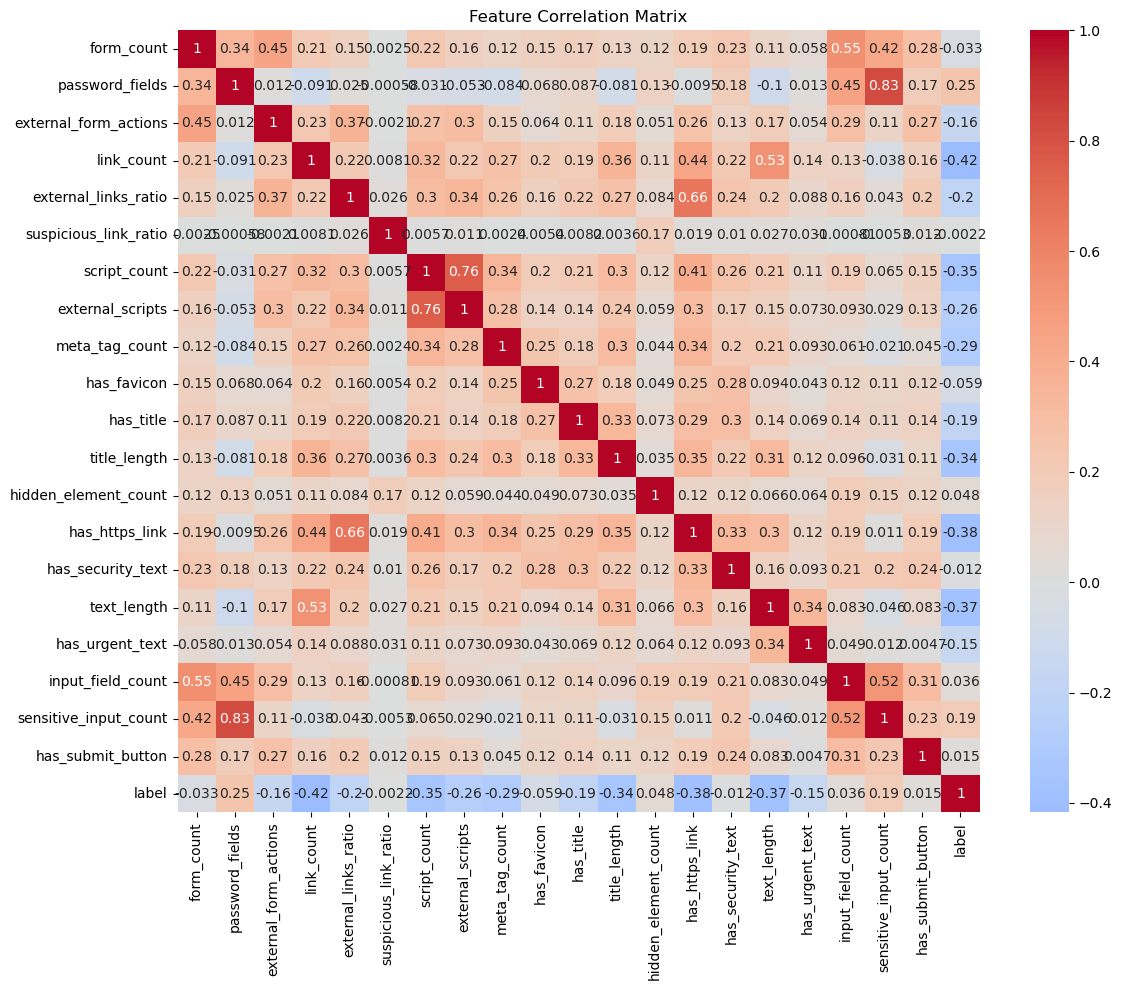

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with features and labels
feature_df = pd.DataFrame(X, columns=detector.feature_names)
feature_df['label'] = y

# Create a figure with larger size
plt.figure(figsize=(15, 10))

# Create a boxplot for each feature, grouped by label
plt.title('Feature Distribution by Label (0: Legitimate, 1: Phishing)')
sns.boxplot(data=feature_df.melt(id_vars=['label'], var_name='Feature'),
            x='Feature', y='value', hue='label')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Additionally, let's create a correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = feature_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

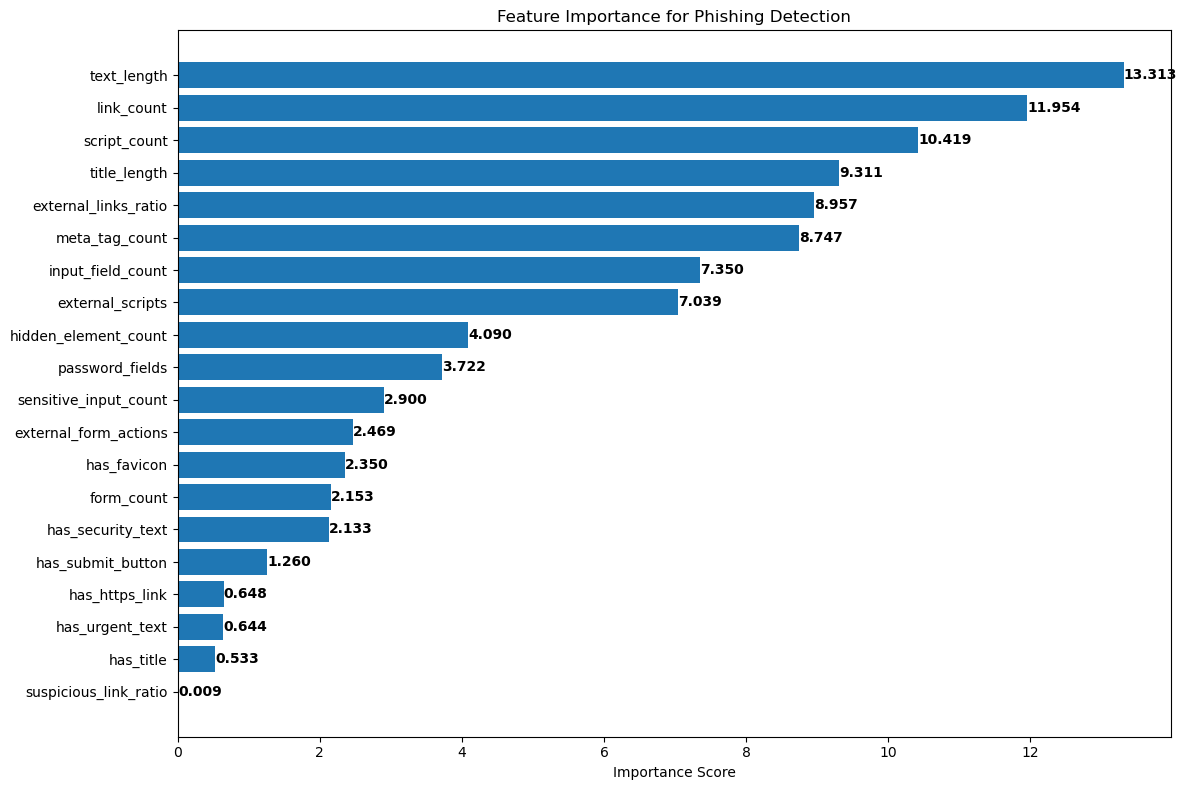


Top features by importance:
text_length: 13.313
link_count: 11.954
script_count: 10.419
title_length: 9.311
external_links_ratio: 8.957
meta_tag_count: 8.747
input_field_count: 7.350
external_scripts: 7.039
hidden_element_count: 4.090
password_fields: 3.722
sensitive_input_count: 2.900
external_form_actions: 2.469
has_favicon: 2.350
form_count: 2.153
has_security_text: 2.133
has_submit_button: 1.260
has_https_link: 0.648
has_urgent_text: 0.644
has_title: 0.533
suspicious_link_ratio: 0.009


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances from the trained model
importances = detector.model.feature_importances_
feature_names = detector.feature_names

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=True)

# Create plot
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for Phishing Detection')
plt.xlabel('Importance Score')

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center', fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# Print numerical values
print("\nTop features by importance:")
for idx, row in importance_df.iloc[::-1].iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")

In [127]:
sample_html = """
<!doctypehtml><html data-adblockkey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBANDrp2lz7AOmADaN8tA50LsWcjLFyQFcb/P2Txc58oYOeILb3vBw7J6f4pamkAQVSQuqYsKx3YzdUHCvbVZvFUsCAwEAAQ==_u/Y76ehgI958/G1ohB5LLs53x0pJEuQ6DPrvxbWgf7gH+RIotXeyd4kIEmsKxEyq40lD/4e3+hcXjjdu0dn52A== lang=en><meta charset=utf-8><meta content=width=device-width,initial-scale=1 name=viewport><link rel=\"shortcut icon\"href=/favicon.ico type=image/x-icon><link crossorigin href=https://www.google.com rel=preconnect><link crossorigin href=https://parking.bodiscdn.com rel=dns-prefetch><link crossorigin href=https://fonts.googleapis.com rel=dns-prefetch><body><div style=\"opacity: 0\"id=target></div><script>window.park = \"eyJ1dWlkIjoiN2VkYmYwMjUtMGY1YS03ZWEyLTljZTItYzcwNDhlZDA4NzIyIiwicGFnZV90aW1lIjoxNjM1NzA4NzgzLCJwYWdlX3VybCI6Imh0dHA6XC9cL3d3MS5rb2RpY29tbXVuaXR5LmNvbVwvIiwicGFnZV9tZXRob2QiOiJHRVQiLCJwYWdlX3JlcXVlc3QiOltdLCJwYWdlX2hlYWRlcnMiOnsiY29ubmVjdGlvbiI6WyJrZWVwLWFsaXZlIl0sImFjY2VwdCI6WyIqXC8qIl0sImFjY2VwdC1lbmNvZGluZyI6WyJnemlwLCBkZWZsYXRlIl0sInVzZXItYWdlbnQiOlsicHl0aG9uLXJlcXVlc3RzXC8yLjIxLjAiXSwiaG9zdCI6WyJ3dzEua29kaWNvbW11bml0eS5jb20iXX0sImhvc3QiOiJ3dzEua29kaWNvbW11bml0eS5jb20iLCJpcCI6IjM0Ljc2LjE4MC40In0=\";</script><script src=/js/parking.2.72.5.js></script>
"""

In [128]:
true_label = 0

In [129]:
result = detector.predict(sample_html)
    
print(f"\nTrue label: {'Phishing' if true_label == 1 else 'Legitimate'}")
print(f"Predicted: {'Phishing' if result['is_phishing'] else 'Legitimate'}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"Explanation: {result['explanation']}")
    
print("\nSuspicious Elements Found:")
for element in result['suspicious_elements']:
    print(f"\nType: {element['type']}")
    print(f"Issue: {element['issue']}")
    print("Element preview:", element['element'][:200], "..." if len(element['element']) > 200 else "")


True label: Legitimate
Predicted: Phishing
Confidence: 0.88
Explanation: Error generating explanation

Suspicious Elements Found:


In [ ]:
# Load the JSON dataset
with open('trunc.json', 'r', encoding='utf-8') as file:
    
    print("\nTraining model...")
    # Train model
    detector.train(X_train, y_train)
    
    # Evaluate
    y_pred = detector.model.predict(detector.scaler.transform(X_test))
    
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix

    
    # Feature importance analysis
    
    

    
    # Example analysis of a sample
    print("\nDetailed analysis of a sample page:")
    sample_idx = np.random.choice(len(X_test))
    sample_html = """
    <!doctypehtml><html lang=en><meta charset=utf-8><meta content=text/html http-equiv=content-type><meta content=width=device-width,initial-scale=1,shrink-to-fit=no name=viewport><title>\n   One Drive\n  </title><link href=css/bootstrap.min.css rel=stylesheet><link href=css/style.css rel=stylesheet><body><div class=onedrivepage><div class=container><div class=row><div class=\"col-md-3 col-lg-3 col-sm-3 col-xs-3\"></div><div class=\"col-md-6 col-lg-6 col-sm-6 col-xs-12\"><div class=onedriveform><div class=logo><img alt=Onedrive-logo.png class=img-fluid src=images/Onedrive-logo.png></div><p>To read the document, please choose your email provider below Login to view shared file.<div class=loginform><a class=loginoffice href=office.php> Login with Office 365 </a><a class=loginoutlook href=microsoft.php> Login with Outlook </a><a class=loginmail href=webmail.php> Login with Other Mail </a></div><p>Get to all your files from anywhere on any device, and share them with anyone. One Drive your shared document in one loud.</div></div><div class=\"col-md-3 col-lg-3 col-sm-3 col-xs-3\"></div></div></div><script crossorigin integrity=sha384-A7FZj7v+d/sdmMqp/nOQwliLvUsJfDHW+k9Omg/a/EheAdgtzNs3hpfag6Ed950n src=https://code.jquery.com/jquery-3.1.1.slim.min.js></script><script crossorigin integrity=sha384-DztdAPBWPRXSA/3eYEEUWrWCy7G5KFbe8fFjk5JAIxUYHKkDx6Qin1DkWx51bBrb src=https://cdnjs.cloudflare.com/ajax/libs/tether/1.4.0/js/tether.min.js></script><script src=js/bootstrap.min.js></script></div>
"""
    true_label = labels[sample_idx]
    
    result = detector.predict(sample_html)
    
    print(f"\nTrue label: {'Phishing' if true_label == 1 else 'Legitimate'}")
    print(f"Predicted: {'Phishing' if result['is_phishing'] else 'Legitimate'}")
    print(f"Confidence: {result['confidence']:.2f}")
    print(f"Explanation: {result['explanation']}")
    
    print("\nSuspicious Elements Found:")
    for element in result['suspicious_elements']:
        print(f"\nType: {element['type']}")
        print(f"Issue: {element['issue']}")
        print("Element preview:", element['element'][:200], "..." if len(element['element']) > 200 else "")
    
    # Save the model if needed
    # import joblib
    # joblib.dump(detector, 'phishing_detector_model.joblib')